<a href="https://colab.research.google.com/github/alexandrosfloros/Summer-Internship-2022/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part I: Extracting images to be labelled from the video data sets.**

Download data set videos:

In [ ]:
!gdown 1wsqB4ATUFYu44mnm1R9qrOGcW6bsWBTR

Unzip videos:

In [ ]:
!unzip videos.zip

Create frames directory:

In [ ]:
!mkdir frames

Import OpenCV:

In [ ]:
import cv2 as cv

The following code is used to read 40 videos of each of the knot-tying, needle-passing and suturing categories from a folder and sample them into images at a specified frame rate. The videos are named as "{category}_{n}", where n is 0-39.

In [ ]:
categories = ["knot", "needle", "suturing"]

rate = 300
count = 0

for category in categories:
    for n in range(40):
        capture = cv.VideoCapture(f"videos/jigsaws/{category}_{n}.avi")
        success, frame = capture.read()
            
        while success:
            if count % rate == 0:
                cv.imwrite(f"frames/frame_{count // rate}.jpg", frame)
            
            success, frame = capture.read()

            count += 1

The following code is used to read 7 peg-transfer videos from a folder and sample them into images at a specified frame rate. The videos are named as "peg_{n}", where n is 0-6.

In [ ]:
rate = 30
count = 998 * rate

for n in range(7):
    capture = cv.VideoCapture(f"videos/peg/peg_{n}.avi")
    success, frame = capture.read()

    while success:
        frame = frame[:, 0:720]
        if count % rate == 0:
            cv.imwrite(f"frames/frame_{count // rate}.jpg", frame)
        
        success, frame = capture.read()

        count += 1

*The obtained images are then labelled using an image annotation tool.*

**Part II: Using labelled data to train the object detection model.**

Install Darknet:

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet

In [ ]:
%cd /content/

Download labelled data set from Google Drive:

In [ ]:
!gdown 1u1L5qhu1Y39V-pTHwfuBF5VwWI0pQz2u

Unzip data set:

In [ ]:
!unzip dataset.zip

Move data to a single path:

In [ ]:
!cp dataset/labels/* dataset/frames
!rm -rf dataset/labels
!cp dataset/frames/* dataset
!rm -rf dataset/frames

Define data set path:

In [ ]:
ds_path = "/content/dataset"

Split data set into *train*, *val* and *test*:

In [ ]:
import random

count = 1100
ids = list(range(count))
random.shuffle(ids)

total = len(ids)
limit_train = int(total * 0.8)
limit_val = int(total * 0.9)

ids_train = ids[:limit_train]
ids_val = ids[limit_train:limit_val]
ids_test = ids[limit_val:]

def create_file(group, path):
  file = open(path, "w")

  for n in group:
    file.write(f"{ds_path}/frame_{n}.jpg\n")
  file.close()

Create data files:

In [ ]:
!mkdir data

create_file(ids_train, "/content/data/train.txt")
create_file(ids_val, "/content/data/val.txt")
create_file(ids_test, "/content/data/test.txt")

Download pretrained weights:

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

Set up object names:

In [ ]:
objnames = "/content/obj.names"

labels = ["left_instrument", "right_instrument"]

with open(objnames, "w") as file:
    file.write("\n".join(labels))

Set up object data:

In [ ]:
import re

objdata = "/content/obj.data"

num_classes = len(labels)   

with open(objdata, "w") as file:
  file.write(f"classes = {num_classes}\n")
  file.write(f"train = /content/data/train.txt\n")
  file.write(f"valid = /content/data/val.txt\n")
  file.write(f"names = /content/obj.names\n")
  file.write(f"backup = backup/")

Set up object test data:

In [ ]:
objdata = "/content/obj_test.data"

num_classes = len(labels)   

with open(objdata, "w") as file:
  file.write(f"classes = {num_classes}\n")
  file.write(f"train = /content/data/train.txt\n")
  file.write(f"valid = /content/data/test.txt\n")
  file.write(f"names = /content/obj.names\n")
  file.write(f"backup = backup/")

Set up config file:

In [ ]:
!cp /content/darknet/cfg/yolov4-tiny-custom.cfg /content/yolov4-tiny.cfg

yolo_version = 4
cfg_file = f"/content/yolov{yolo_version}-tiny.cfg"
weights_file = "/content/yolov4-tiny.conv.29"

In [ ]:
yolo_height = 320
yolo_width = 512

max_batch = num_classes * 2000

step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

num_filters = (num_classes + 5) * 3

batch = 64
subdivisions = 4

In [ ]:
with open(cfg_file) as f:
    s = f.read()

s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
s = re.sub('batch=\d*', 'batch='+str(batch), s)
s = re.sub('subdivisions=\d*', 'subdivisions='+str(subdivisions), s)
s = re.sub('height=\d*', 'height='+str(yolo_height), s)
s = re.sub('width=\d*', 'width='+str(yolo_width), s)

s = re.sub('CUDNN=0','CUDNN=1',s)
s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  s = re.sub('GPU=0','GPU=1',s)
  f.write(s)

Move to darknet directory:

In [ ]:
%cd /content/darknet/

Train model (optional, the weights have already been trained):

In [ ]:
!./darknet detector train /content/obj.data $cfg_file $weights_file -dont_show -ext_output -map

Define weights path:

In [ ]:
weights_best = "/content/darknet/backup/yolov4-tiny_best.weights"

Download weights already trained (unless new ones have been trained now):

In [ ]:
%cd /content/darknet/backup
!gdown 1l-1qu1zNEWfpoREYpwiMQsZtfMWhWOAL
%cd ..

Test with image:

In [ ]:
!./darknet detector test /content/obj.data  $cfg_file  $weights_best /content/dataset/frame_0.jpg -ext_output

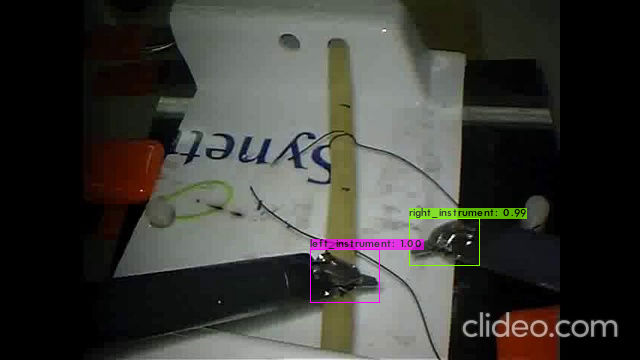

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

img = cv.imread("predictions.jpg")
cv2_imshow(img)

Evaluate model:

In [ ]:
!./darknet detector map /content/obj_test.data $cfg_file $weights_best -points 0

Save model weights:

In [ ]:
from google.colab import files
files.download(weights_best)

Download demo images:

In [ ]:
!gdown 11ZbeO6KUVxYrQVNl7bRENmb8EEQUbeFt

Unzip images:

In [ ]:
!unzip samples.zip

Create demo videos:

In [ ]:
categories = ["knot", "needle", "suturing", "peg"]

for category in categories:
    video = cv.VideoWriter(f"{category}.avi", cv.VideoWriter_fourcc(*"DIVX"), 30, (640, 480))

    for n in range(500):
        !./darknet detector test /content/obj.data  $cfg_file  $weights_best /content/darknet/samples/{category}/frame_{n}.jpg -ext_output
        frame = cv.imread("predictions.jpg")
        if category == "peg":
            frame = frame[0:480, 40:680]

        video.write(frame)